In [63]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np

from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader

In [64]:
# define this! The rest can remain untouched
molecule = 'h2o'
data_dir = Path(f'./{molecule}_energies_noise_scf_features')
n_atoms = 27

In [65]:
C = [] # xyz coordinates
X = [] # calculated SCF matrix features
Y = [] # calculated energies

for file_path in data_dir.glob('*.npz'):
    data_file = np.load(file_path)
    try:
        C.append(data_file['coords'])
        X.append(data_file['features'])
        Y.append(data_file['energy'])

    except KeyError:
        raise KeyError('wrong key for npz file!')
# you must perform stacking, cannot just convert to array    
N, n_atoms, n_features, channels = np.stack(X).shape
X = np.stack(X).reshape(N, n_atoms, n_features * channels)  # (N, n_atoms, n_features * channels    )
C = np.stack(C)
Y = np.stack(Y)
print(X.shape)
print(Y.shape)

(1000, 3, 70)
(1000,)


In [66]:
def hartree_to_kcal_per_mol(Y):
    return Y * 627.50961

Y = hartree_to_kcal_per_mol(Y)

In [67]:
x_train, x_valtest, y_train, y_valtest, c_train, c_valtest = train_test_split(X, Y, C, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test, c_val, c_test = train_test_split(x_valtest, y_valtest, c_valtest, test_size=0.33, random_state=42)
print(x_train.shape, y_train.shape, c_train.shape)
print(x_val.shape, y_val.shape, c_val.shape)
print(x_test.shape, y_test.shape, c_test.shape)

(700, 3, 70) (700,) (700, 3, 3)
(201, 3, 70) (201,) (201, 3, 3)
(99, 3, 70) (99,) (99, 3, 3)


Of course, we can define the edge features as well

In [90]:
from scipy import sparse 

def build_adjacency_from_xyz(coords, threshold=2.0):
    """
    Given coords: (n_atoms, 3), returns (n_atoms, n_atoms) adjacency matrix
    with 1s where Euclidean distance < threshold and 0 elsewhere (excluding self-loops)
    """
    n = coords.shape[0]
    dists = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    A = (dists < threshold).astype('float32')
    np.fill_diagonal(A, 0.0)  # remove self-loops
    # print(A)
    return sparse.csr_matrix(A)  # return as sparse matrix for efficiency; spektral expects this forma or np array (more expensive)

class SCFAtomGraphDataset(Dataset):
    def __init__(self, X, Y, C,
                 threshold=2.0, **kwargs):
        """
        Dataset for SCF atom graphs.
        """
        self.X = X.astype('float32')         # (N, n_atoms, n_features, 5)
        self.Y = Y.astype('float32')         # (N,)
        self.C = C.astype('float32')         # (N, n_atoms, 3)
        self.threshold = threshold
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for x, y, c in zip(self.X, self.Y, self.C):
            A = build_adjacency_from_xyz(c, threshold=self.threshold)  # shape (n_atoms, n_atoms)
            graphs.append(Graph(x=x, a=A, y=np.array([y])))
        return graphs

In [69]:
from spektral.layers import GraphSageConv, GlobalSumPool
'''
tried: GCNConv (only accepts [x,a], cannot accept disjoint batches
GCSConv (shape mismatch)
GINConv (tf error)
GraphSageConv + disable XLA flag + operate on CPU (forced). Both must be present for it work somehow.
'''

class GNNModel(tf.keras.Model):
    def __init__(self, y_mean):
        super().__init__()
        he_init = tf.keras.initializers.HeNormal()

        # ReLU and GeLU layers are best with HeNormal. Default is GlorotUniform, which isn't the most ideal
        self.conv1 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros') 
        self.conv2 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros')
        self.pool = GlobalSumPool()
        self.dense = tf.keras.layers.Dense(1, 
                                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),
                                           bias_initializer=tf.keras.initializers.Constant(y_mean))

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.pool([x, i])
        return self.dense(x)


In [78]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def train_GNN(x_train, y_train, c_train,
              x_val, y_val, c_val,
              epochs=10, batch_size=32, threshold=1.5, verbose=0):
    # Create dataset
    train_dataset = SCFAtomGraphDataset(x_train, y_train, c_train, threshold=threshold)

    # tried: SingleLoader (not compatible with N,3,3 data)
    train_loader = DisjointLoader(train_dataset, epochs=epochs, batch_size=batch_size, shuffle=True)

    val_dataset = SCFAtomGraphDataset(x_val, y_val, c_val, threshold=threshold)
    val_loader = DisjointLoader(val_dataset, epochs=epochs, batch_size=batch_size, shuffle=False)

    # idx = np.arange(len(X))
    # rng = np.random.default_rng(42)
    # rng.shuffle(idx)

    # split = int(0.8 * len(idx))
    # tr_idx, va_idx = idx[:split], idx[split:]

    # train_ds = SCFAtomGraphDataset(X[tr_idx], Y[tr_idx], C[tr_idx], threshold=2.0)
    # val_ds   = SCFAtomGraphDataset(X[va_idx], Y[va_idx], C[va_idx], threshold=2.0)

    # train_loader = DisjointLoader(train_ds, batch_size=32, shuffle=True)   # Keras Sequence ✅
    # val_loader   = DisjointLoader(val_ds,   batch_size=32, shuffle=False)
    
    
    # # Build and compile model
    # with tf.device('/CPU:0'):
    model = GNNModel(y_mean=y_train.mean())
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6)
    model.compile(optimizer='adam', loss='mse')

    # Train
    history = model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, 
                        validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
                        epochs=epochs, verbose=verbose, callbacks=[lr_scheduler])    
    
    return model, history.history

In [79]:
gnn_model, history = train_GNN(x_train=x_train,y_train=y_train, c_train=c_train,
                           x_val=x_val,y_val=y_val,c_val=c_val,
                           epochs=5000, verbose=0)

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


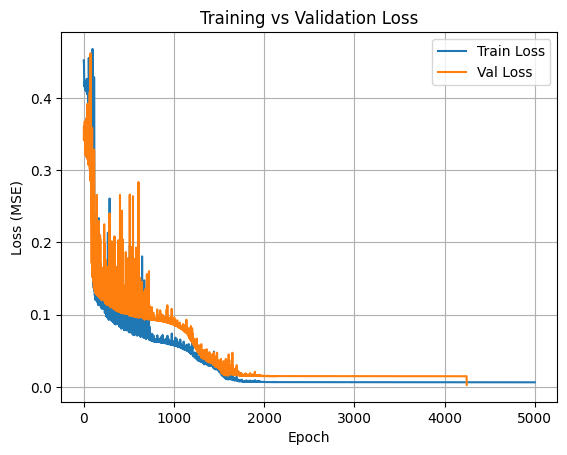

In [80]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [81]:
print(x_test.shape, y_test.shape)

(99, 3, 70) (99,)


In [84]:
# Create test dataset and loader
test_dataset = SCFAtomGraphDataset(x_test, y_test, c_test, threshold=1.5)
test_loader = DisjointLoader(test_dataset, epochs=1, batch_size=32, shuffle=False)

# Evaluate on test set
test_loss = gnn_model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print(f"Test MSE loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 
Test MSE loss: 0.01


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
y_pred shape: (99,)


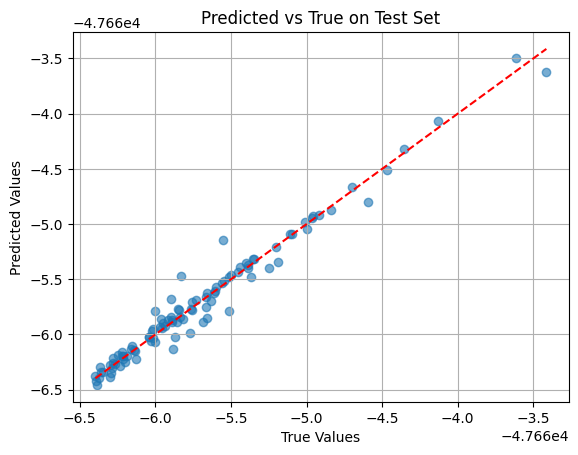

In [88]:
# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = gnn_model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()


In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MAE: 6.358825e-02
R²:  0.9711


In [87]:
model_dir = Path('./gnn_model/')
model_dir.mkdir(parents=True, exist_ok=True)

gnn_model.save(model_dir / 'h2o_gnn_model_scf_features.keras')

## Test on translational invariance

In [19]:
# Evaluation on: CNN, GNN. We have x_test, y_test
from numpy.random import default_rng

def translation(X, offset=10.0):
    '''
    Offset: a (3,) vector (tuple) or a scaler. 
    '''
    off = np.asarray(offset)
    if off.ndim == 0:
        off = np.array([off, off, off])
    return X + off  # broadcasting: (N,n_atoms,3) + (3,) → (N,n_atoms,3)

def rotate_180_y_axis(X):
    R = np.array([[-1, 0, 0],
              [ 0, 1, 0],
              [ 0, 0,-1]])
    return X @ R.T

def permutation(X, seed=None):
    N, n_atoms, xyz = X.shape
    rng = default_rng(seed)          # create a Generator with seed 42
    perm = rng.permutation(n_atoms)
    return X[:, perm, :]

Step 1: save test dataset's energies and xyz coordinates

In [20]:
x_test.shape, y_test.shape, c_test.shape

((99, 3, 70), (99,), (99, 3, 3))

In [21]:
np.save(f'./test_xyz_{molecule}.npy', c_test)

In [27]:
x_test = np.load('./test_scf_h2o_permutated.npy')
y_test = y_test
c_test =np.load('./test_xyz_h2o_permutated.npy')

In [28]:
print(x_test.shape, y_test.shape, c_test.shape)

(99, 3, 70) (99,) (99, 3, 3)


In [29]:
# Create test dataset and loader
test_dataset = SCFAtomGraphDataset(x_test, y_test, c_test, threshold=1.5)

# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = gnn_model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

from sklearn.metrics import  mean_absolute_error

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mae = mean_absolute_error(y_test, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE: 7.125822e+00
R²:  0.9398
